In [1]:
library(Rtsne)
library(cowplot)
library(tidyverse)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ purrr::flatten()  masks jsonlite::flatten()
✖ cowplot::ggsave() masks ggplot2::ggsave()
✖ dplyr::lag()      masks stats::lag()


In [2]:
read_expression <- function(tumor) {
    
    tx2gene <- read_csv('../data/tx2gene.csv', col_types = 'cc')
    
    xpr <- lapply(c('Case', 'Control'), function(x, tumor, tx2gene) {

        read_tsv(paste0('../data/expression/', tumor, '_', x, '_isoform_tpm.tsv'), 
                 col_types = cols(transcript = "c", .default = 'd')) %>%
            gather(key = 'sample', value = 'expression', -transcript) %>%
            inner_join(tx2gene, by = 'transcript') %>%
            group_by(gene, sample) %>%
            summarize(expression = sum((2^expression) - .001)) %>%
            ungroup %>%
            mutate(expression = pmax(expression, 0),
                   expression = log2(expression + .001)) %>%
            spread(key = 'sample', value = 'expression')
        
    }, tumor, tx2gene)
  
    dims <- lapply(xpr, function(x) ncol(x) - 1)
    xpr <- inner_join(xpr[[1]], xpr[[2]], by = 'gene')
    genes <- xpr$gene
    xpr <- select(xpr, -gene) %>% data.matrix
    row.names(xpr) <- genes
    colnames(xpr) <- c(rep('Case', dims[1]), rep('Control', dims[2]) )
    xpr <- xpr[!duplicated(xpr),]
                  
    return(t(xpr))
}
                   
plot_tSNE <- function(x, title) {
    y <- rownames(x)
    Rtsne(x, dims = 2, perplexity=30, verbose=TRUE, max_iter = 500) %>%
    .$Y %>%
    as_tibble %>%
    mutate(label = y, x = V1, y = V2) %>%
    ggplot(aes(x = x, y = y, color = label)) +
        geom_point() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(title = title, color = 'Origin')
}

In [3]:
all <- read_expression('ALL')
all_plt <- plot_tSNE(all, 'ALL')

aml <- read_expression('AML')
aml_plt <- plot_tSNE(aml, 'AML')

Read the 156 x 50 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Normalizing input...
Building tree...
 - point 0 of 156
Done in 0.01 seconds (sparsity = 0.749425)!
Learning embedding...
Iteration 50: error is 54.862052 (50 iterations in 0.05 seconds)
Iteration 100: error is 58.293178 (50 iterations in 0.05 seconds)
Iteration 150: error is 58.978731 (50 iterations in 0.05 seconds)
Iteration 200: error is 60.221469 (50 iterations in 0.06 seconds)
Iteration 250: error is 57.473806 (50 iterations in 0.06 seconds)
Iteration 300: error is 1.445359 (50 iterations in 0.05 seconds)
Iteration 350: error is 0.831299 (50 iterations in 0.04 seconds)
Iteration 400: error is 0.578724 (50 iterations in 0.04 seconds)
Iteration 450: error is 0.526942 (50 iterations in 0.04 seconds)
Iteration 500: error is 0.521881 (50 iterations in 0.04 seconds)
Fitting performed in 0.49 seconds.
Read the 167 x 50 data matrix successfully!
Using

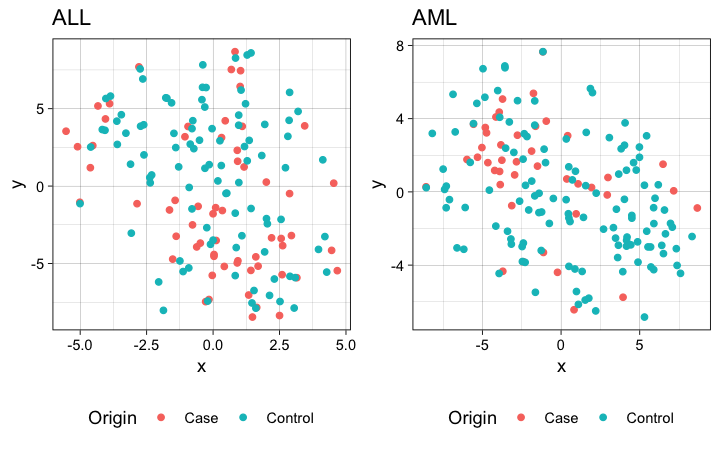

In [4]:
options(repr.plot.width=6, repr.plot.height=3.75)
plot_grid(all_plt, aml_plt)